In [1]:
! pip install pytorch-nlp


     |████████████████████████████████| 92kB 4.9MB/s 


In [0]:
import torch
import numpy as np
import torch.nn as nn
import torchtext

from torchtext.data import TabularDataset, Field, Iterator
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from torch import optim 
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchnlp.nn import Attention

import copy
import time
from collections import namedtuple
from tqdm import tqdm, tqdm_notebook

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd drive/"My Drive"/NN4NLP/topicclass

/content/drive/My Drive/NN4NLP/topicclass


In [5]:
! ls

bestMobile_v2_NetModel.pt
Classifier.ipynb
ConvNetClassificationTesting_10.txt
ConvNetClassificationTesting_11.txt
ConvNetClassificationTesting_12.txt
ConvNetClassificationTesting_13.txt
ConvNetClassificationTesting_2.txt
ConvNetClassificationTesting_3.txt
ConvNetClassificationTesting_4.txt
ConvNetClassificationTesting_5.txt
ConvNetClassificationTesting_6.txt
ConvNetClassificationTesting_7.txt
ConvNetClassificationTesting_8.txt
ConvNetClassificationTesting_9.txt
ConvNetClassificationTesting_real_10.txt
ConvNetClassificationTesting_real_11.txt
ConvNetClassificationTesting_real_12_redo.txt
ConvNetClassificationTesting_real_12.txt
ConvNetClassificationTesting_real_13_redo.txt
ConvNetClassificationTesting_real_13.txt
ConvNetClassificationTesting_real_14_redo.txt
ConvNetClassificationTesting_real_14.txt
ConvNetClassificationTesting_real_15_redo.txt
ConvNetClassificationTesting_real_15.txt
ConvNetClassificationTesting_real_16_redo.txt
ConvNetClassificationTesting_real_16.txt
ConvNetClassific

In [0]:
# ! wget "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"

In [0]:
#! wget "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip"

In [0]:
# ! unzip crawl-300d-2M-subword.zip

In [0]:
# ! unzip crawl-300d-2M.vec.zip

In [0]:
int2Label = \
{0: 'Miscellaneous',
 1: 'Video games',
 2: 'Language and literature',
 3: 'Music',
 4: 'Social sciences and society',
 5: 'Sports and recreation',
 6: 'Natural sciences',
 7: 'Art and architecture',
 8: 'History',
 9: 'Warfare',
 10: 'Engineering and technology',
 11: 'Philosophy and religion',
 12: 'Agriculture, food and drink',
 13: 'Geography and places',
 14: 'Mathematics',
 15: 'Media and drama'}

In [0]:
np.random.seed(11747)
LOWER = False
LEARNING_RATE = 3e-4
N_CLASS = len(int2Label.keys())
MODELNO = "real_56"
LOG_FILE = "ConvNetClassificationTesting_" + str(MODELNO) + ".txt"
VERBOSE_LOG_FILE = "VerboseConvNetClassificationTesting_" + str(MODELNO) + ".txt"
STEP_SIZE = 5
GAMMA = 1.0
NUMBER_EPOCHS = 10
EMBEDDING_DIM = 300

In [0]:
f = open(LOG_FILE,"w+")
v = open(VERBOSE_LOG_FILE, "w+")

In [0]:
tokenizer = get_tokenizer("spacy")

TEXT = Field(sequential=True, tokenize=tokenizer, lower=LOWER, batch_first=True )

LABEL = Field(sequential=False, use_vocab=False, batch_first=True)

In [0]:
train, val, test = TabularDataset.splits(".", 
                                            train = "topicclass_train.csv", 
                                            validation = "topicclass_valid_fixed.csv", 
                                            test = "topicclass_test.csv", 
                                            format = "csv", 
                                            skip_header = True,
                                            fields = [('label', LABEL), ('text', TEXT)])

In [0]:
TEXT.build_vocab(train, val, test)

In [0]:
embedding_mtx = torch.load("embedding_mtx.pt")

In [0]:
# defined_vocab = set()
# num_lines = 2000000

# with open("crawl-300d-2M.vec") as vec_file: 
#   for i, line in enumerate(tqdm_notebook(vec_file, total=num_lines)): 
#     if i == 0: 
#       pass
#     else: 
#       word, vector = line.split(" ", 1)
#       if word in TEXT.vocab.stoi: 
#         embedding_mtx[TEXT.vocab.stoi.get(word)] =  torch.from_numpy(np.fromstring(vector, sep = " "))
#         defined_vocab.add(word)



In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
print("device is: {}".format(device))
f.write("device is: {}\n".format(device))
v.write("device is: {}\n".format(device))

device is: cuda:0


18

In [0]:
train_loader, val_loader = Iterator.splits(
                                    (train, val), 
                                    batch_sizes = (64, 64), 
                                    shuffle = True, 
                                    sort_key = lambda x: len(x.text), 
                                    device = device, 
                                    )

test_loader = Iterator(test, batch_size=64, device = device)

In [0]:
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train), 'val': len(val)}

Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])

In [0]:
class AttnClassifier(nn.Module): 
    def __init__(self, embeddings, n_class, dim_feedforward = 1024, n_head = 4, n_layer = 1, dropout = 0.1): 
        super().__init__()
        self.vocab_size, self.embedding_size = embeddings.shape
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_size, sparse = False)
        self.embedding.weight.data.copy_(embeddings)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model = 300, dim_feedforward = dim_feedforward, nhead = n_head)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, n_layer)
    
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.embedding_size, n_class)
        
    def forward(self, texts): 
        with torch.no_grad(): 
            embeddings = self.embedding(texts)

        transformer_out = self.transformer_encoder(embeddings)
        # print(transformer_out.shape)

        pool = nn.MaxPool1d(kernel_size = transformer_out.shape[1])
#         print(f"conv2 shape is {conv2_out.shape}")
        
        pooled_out = pool(transformer_out.transpose(1,2)).squeeze(2)

        # print(f"embeddings shape {embeddings.shape} and attn out is {attn_out.shape} and pooled_out is {pooled_out.shape}")
        
#         print(f"pooled out shape is {pooled_out.shape}")
        pooled_out = self.dropout(pooled_out)
        out = self.fc(pooled_out)
        
        return out
        
        
        
        
        
        

In [0]:
def init_weights(m):
    if type(m) == nn.Conv1d or type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, lambda_reg = .0001):

    since = time.time()
    
    best_acc = 0.0

    for epoch in range(num_epochs):
        f.write('Epoch {}/{}\n'.format(epoch+1, num_epochs))
        v.write('Epoch {}/{}\n'.format(epoch+1, num_epochs))
        f.write('-' *10)
        v.write('-' * 10)

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            f.write("\nstarting epoch {} for {} phase\n".format(epoch+1, phase))
            v.write("\nstarting epoch {} for {} phase\n".format(epoch+1, phase))
            print("starting epoch {} for {} phase".format(epoch+1, phase))

            for i, data in enumerate(tqdm_notebook(dataloaders[phase])):
                #pdb.set_trace()
                inputs = data.text.to(device)
                labels = data.label.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) 
                    # for i, param in enumerate(model.parameters()): 
                    #   if i == 1: 
                    #     loss += lambda_reg * torch.norm(param)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if ((i%300) == 0):
                    #print("inside")
                    v.write("inputs size: {}\n".format(inputs.size(0)))
                    v.write("epoch {}, batch {},  loss : {}\n".format(epoch+1, i, loss.item()))
                    v.write("percent correct: {}\n".format((torch.sum(preds == labels.data)/inputs.size(0))))
            
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':

                train_loss = epoch_loss
                train_error = 1 - epoch_acc
                scheduler.step()

            elif phase == 'val': 

                val_error = 1 - epoch_acc
                metrics.append(Metric(loss=train_loss, train_error=train_error,val_error=val_error))
            
            f.write('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc))
            v.write('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                PATH = 'MobileNetModel_' + str(epoch+2) + '.pt'
                torch.save(model, PATH)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    f.write('Training complete in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    v.write('Training complete in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))


    print('Best val Acc: {:4f}'.format(best_acc))

    f.write('Best val Acc: {:4f}'.format(best_acc))
    v.write('Best val Acc: {:4f}'.format(best_acc))


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
model = AttnClassifier(embedding_mtx, N_CLASS, dim_feedforward=2048, n_head = 10, n_layer = 1, dropout = 0.5)
model = model.to(device)
model.apply(init_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


Epoch 1/10
----------
starting epoch 1 for train phase



train Loss: 0.9866 Acc: 0.7046
starting epoch 1 for val phase



val Loss: 0.5611 Acc: 0.8507


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AttnClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Epoch 2/10
----------
starting epoch 2 for train phase



train Loss: 0.7313 Acc: 0.7722
starting epoch 2 for val phase



val Loss: 0.5414 Acc: 0.8460

Epoch 3/10
----------
starting epoch 3 for train phase



train Loss: 0.6639 Acc: 0.7912
starting epoch 3 for val phase



val Loss: 0.5523 Acc: 0.8554

Epoch 4/10
----------
starting epoch 4 for train phase



train Loss: 0.6110 Acc: 0.8074
starting epoch 4 for val phase



val Loss: 0.5545 Acc: 0.8336

Epoch 5/10
----------
starting epoch 5 for train phase



train Loss: 0.5665 Acc: 0.8207
starting epoch 5 for val phase



val Loss: 0.5712 Acc: 0.8351

Epoch 6/10
----------
starting epoch 6 for train phase



train Loss: 0.5293 Acc: 0.8323
starting epoch 6 for val phase



val Loss: 0.6329 Acc: 0.8149

Epoch 7/10
----------
starting epoch 7 for train phase



train Loss: 0.4996 Acc: 0.8416
starting epoch 7 for val phase



val Loss: 0.6071 Acc: 0.8180

Epoch 8/10
----------
starting epoch 8 for train phase



train Loss: 0.4732 Acc: 0.8490
starting epoch 8 for val phase



val Loss: 0.6305 Acc: 0.8118

Epoch 9/10
----------
starting epoch 9 for train phase



val Loss: 0.6845 Acc: 0.7994

Epoch 10/10
----------
starting epoch 10 for train phase



train Loss: 0.4301 Acc: 0.8615
starting epoch 10 for val phase



val Loss: 0.6264 Acc: 0.8196

Training complete in 10m 16s
Best val Acc: 0.855365


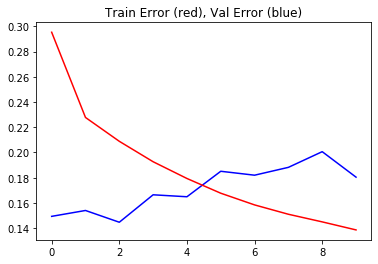

In [38]:
metrics = []
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=NUMBER_EPOCHS, lambda_reg = 0)

f.close()
v.close()
torch.save(model, "Model_" + str(MODELNO) + ".pt")

def training_plot(metrics):
    plt.figure(1)
    plt.plot([m.val_error for m in metrics], 'b')
    plt.plot([m.train_error for m in metrics], 'r')
    plt.title('Train Error (red), Val Error (blue)')
    plt.savefig('Model_' + str(MODELNO) + '.png')
 
training_plot(metrics)
